# 3–2–1 Crack Spread: a tiny quant project

Refineries buy **crude oil** and sell **gasoline** + **diesel**.  
A quick proxy for their gross margin is the **3–2–1 crack**:

**Crack (all in $/bbl$):**

crack = 2×gasoline + 1×diesel − 3×crude

Gasoline (`RB=F`) and diesel (`HO=F`) are in $/gal$ → multiply by 42 to get $/bbl$.

**Goal:** build the crack series from free data, see when margins look unusual (z-score),
check seasonality (driving season), and try a tiny “toy rule” (for learning, not trading).

### Questions
- When do refining margins look **unusually high/low** versus recent history?
- Is there a **seasonal pattern** (e.g., summer driving)?
- Do refiner stocks (**CRAK**) and crude (**CL=F**) behave differently when margins are **rich / neutral / cheap**?
- If I use a simple rule (“only long CRAK when margins are rich”), how does that **behave** (return/vol/drawdown)?

In [29]:
# turn off inline rendering for this notebook session
import matplotlib as mpl
mpl.use("Agg")          # non-interactive backend = no auto-display
import matplotlib.pyplot as plt
plt.ioff()              # belt & suspenders

### Setup & imports

Point Python at my `src/` folder so I can import my helper functions (`cracklib`), and set a start date.

In [30]:
from pathlib import Path
import sys
PROJ = Path.cwd()
if not (PROJ / "src").exists():
    PROJ = PROJ.parent
sys.path.append(str(PROJ / "src"))

from cracklib import (
    TICKERS, EVENTS, REPO_DIR, DATA_DIR,
    download_prices, build_crack_panel, write_dashboard,
    save_plots_with_events, plot_seasonality,
    compute_conditional_forward_returns,
    toy_rule, toy_rule_summary_and_plot,
    PANEL_CSV, COND_TXT, PLOT_LVL, PLOT_ZS, SEASONAL_PNG,
    TOY_EQUITY_PNG, TOY_EQUITY_CL_PNG, TOY_SUMMARY_TXT
)
START = "2010-01-01"

### Data
- Source: Yahoo Finance tickers  
  - `CL=F` WTI crude ($/bbl)  
  - `RB=F` RBOB gasoline ($/gal) → × 42 = $/bbl  
  - `HO=F` Heating oil ($/gal) → × 42 = $/bbl  
  - `CRAK` VanEck refiner ETF (for a rough “refiner equity” proxy)
- Frequency: daily closes.  
- This is **educational** only — no costs/slippage/roll, and ETF ≠ pure crack.

**Dashboard (today):** shows the latest crack value, its z-score (vs last 252 trading days),
which bucket that falls in (**rich / neutral / cheap**), and the 21-day change in $/bbl.

In [31]:
px = download_prices(TICKERS, start=START)
panel = build_crack_panel(px)
print(write_dashboard(panel))
panel.tail()

Date: 2025-09-19
Crack ($/bbl): 76.41
Z-score (252d): 0.75
Regime: neutral
21d change ($/bbl): -8.48



,CL_$/bbl,RBOB_$/bbl,HO_$/bbl,crack_321,crack_z_252,regime
Date,,,,,,
2025-09-15,63.299999,84.562803,97.906199,77.131808,0.831693,neutral
2025-09-16,64.519997,85.747200,100.527004,78.461413,0.925089,neutral
2025-09-17,64.050003,85.205405,98.901599,77.162400,0.820532,neutral
2025-09-18,63.570000,84.478799,98.279996,76.527596,0.765939,neutral
2025-09-19,62.650002,83.462401,97.439997,76.414794,0.750892,neutral


### Crack level over time

Higher = fatter refining margins, lower = thinner. Vertical lines mark big events (COVID, Russia–Ukraine).

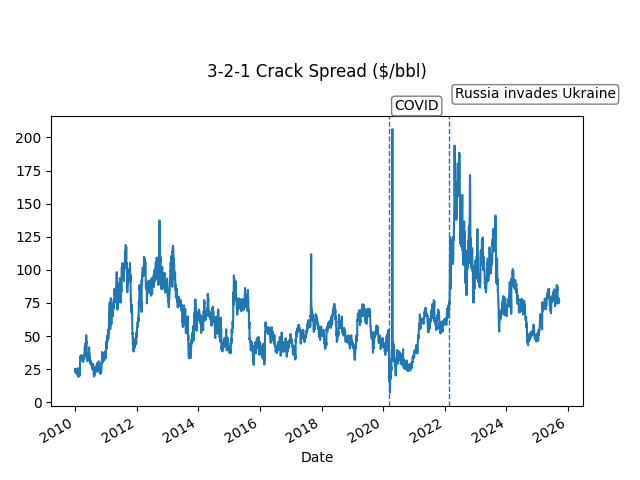

In [32]:
from IPython.display import Image, display

# write the PNGs
save_plots_with_events(panel)

# display them
display(Image(filename=str(PLOT_LVL), width=900))

### Z-score of crack (252 trading days)

Z-score > **+1** → unusually **rich** margins; Z-score < **–1** → unusually **cheap**.  
This normalizes the level so “how unusual is this vs recent history?” is obvious.

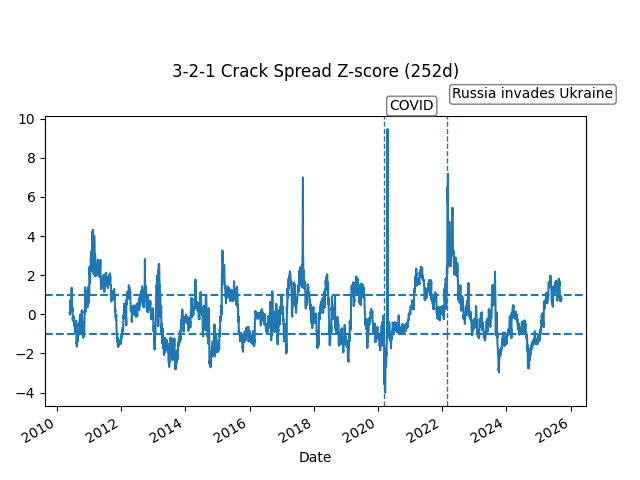

In [33]:
display(Image(filename=str(PLOT_ZS),   width=900))

### Seasonality (monthly average)

Average crack by month. The shaded band (May–Sep) is US driving season. I expect a mild lift there.

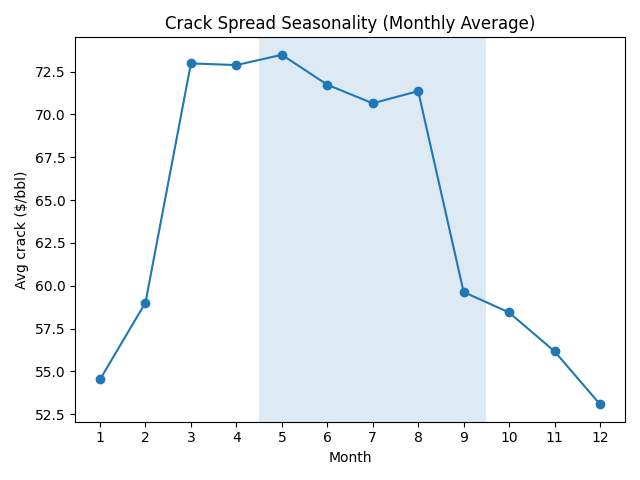

In [34]:
# seasonality (this one should return a path if you updated it)
sp = plot_seasonality(panel)  # if this returns None, just use SEASONAL_PNG constant
display(Image(filename=str(sp or SEASONAL_PNG), width=700))

### What tends to happen next?

Forward 21-day log returns for CL=F and CRAK **grouped by regime** (rich / neutral / cheap).  
`ann_mean` and `ann_sharpe` are annualized so the scale is familiar.

In [35]:
tbl = compute_conditional_forward_returns(panel, px)
tbl

,asset,regime,count,mean,ann_mean,std,ann_sharpe
0,CL=F,cheap (low margin),797,-0.026891,-0.322698,0.121942,-0.763925
1,CL=F,neutral,2104,0.008907,0.106883,0.120207,0.256679
2,CL=F,rich (high margin),893,0.001137,0.013646,0.091929,0.042851
3,CRAK,cheap (low margin),520,0.002324,0.027891,0.070996,0.113409
4,CRAK,neutral,1442,0.008137,0.097646,0.079643,0.353927
5,CRAK,rich (high margin),556,0.012207,0.146480,0.061015,0.693022


### Toy rule (for intuition only)

- **CRAK:** long only when crack z-score > +1 (rich margins), otherwise flat.  
- **CL=F:** short only when crack z-score < –1 (cheap margins), otherwise flat.  

This isn’t tradable as-is (no costs, slippage, borrow). It just shows how the regime maps to asset moves.

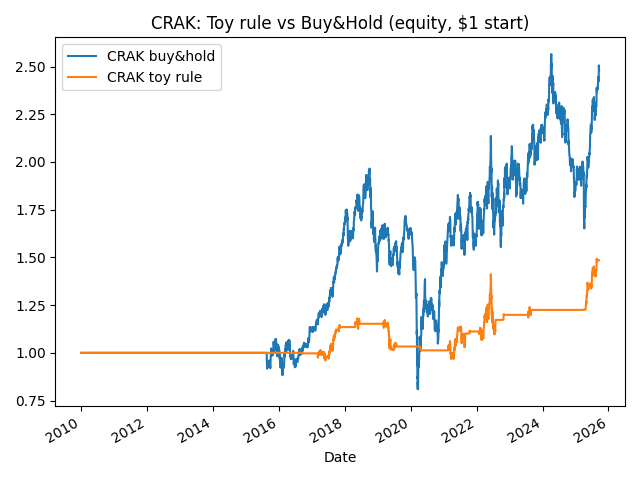

In [36]:
# toy rule (these are constants too)
tr = toy_rule(panel, px)
summary = toy_rule_summary_and_plot(tr)
display(Image(filename=str(TOY_EQUITY_PNG),    width=900))

**CRAK toy rule:** Only participates during “rich” margins → lower exposure in weak periods by design.

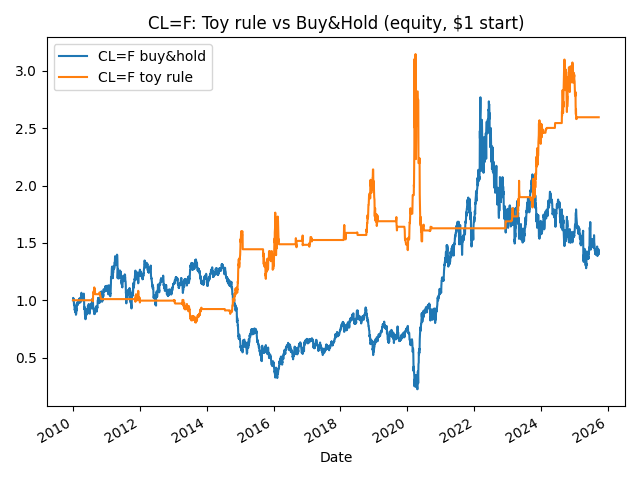

In [37]:
display(Image(filename=str(TOY_EQUITY_CL_PNG), width=900))

### Stats (from the toy rule run)

Quick look at annualized return/vol, Sharpe, and max drawdown for the rule. 

In [38]:
print(summary)

CRAK toy rule (long when crack_z>+1, else 0):
  Ann. return:   0.039
  Ann. vol:      0.092
  Sharpe:        0.427
  Max drawdown: -0.223

CL=F toy rule (short when crack_z<-1, else 0):
  Ann. return:   0.061
  Ann. vol:      0.217
  Sharpe:        0.281
  Max drawdown: -0.519



## Takeaways

- Crack spread reacts to big macro shocks (see event lines).  
- Z-score helps flag unusual periods vs recent history.  
- Seasonality shows a mild summer lift on average.  
- CRAK tends to behave better when margins are rich; crude’s behavior varies by regime.  
- The toy rule reduces exposure when margins aren’t supportive, but it ignores costs/implementation.

## Limitations & next steps

- No transaction costs or turnover impact; add a simple cost model.  
- CRAK ≠ pure crack; a proper test would use futures (and handle roll).  
- Use an in-sample / out-of-sample split for thresholds.  
- Add EIA inventories (gasoline/distillate) to explain crack moves week-to-week.  
- Try other cracks (e.g., 2–1–1) or regional variants.